# 5 Pretraining on Unlabeled Data

In [1]:
from importlib.metadata import version
pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.1
tiktoken version: 0.8.0
torch version: 2.5.1
tensorflow version: 2.18.0


In [2]:
import torch 
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
print("")

In [3]:
import tiktoken 
from previous_chapters import generate_text_simple 

def text_to_token_ids(text , tokenizer):
  encoded = tokenizer.encode(text , allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor 

def token_ids_to_text(token_ids , tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model = model , idx = text_to_token_ids(start_context , tokenizer),
                                 max_new_tokens = 10 , context_size=GPT_CONFIG_124M['context_length'])
print(f"Output text : \n" , token_ids_to_text(token_ids , tokenizer))

Output text : 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
inputs = torch.tensor([[16833 , 3626 , 6100],[40,1107,588]]) #["every effort moves" , "I really like"]
targets = torch.tensor([[3626 , 6100 , 345],[1107,588,11311]]) #["effort moves you" , "really like chocolate"]
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits , dim = -1)
probas.shape

torch.Size([2, 3, 50257])

In [5]:
token_ids = torch.argmax(probas , dim = -1 , keepdim = True)
print("Token IDs:\n" , token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [6]:
print(f"Targets batch 1 : { token_ids_to_text(targets[0] , tokenizer)}")
print(f"Outputs batch 1 : "
      f" {token_ids_to_text(token_ids[0].flatten() , tokenizer)}")

Targets batch 1 :  effort moves you
Outputs batch 1 :   Armed heNetflix


In [7]:
text_idx = 0 
target_probas_1 = probas[text_idx , [0,1,2],targets[text_idx] ]
print("Text 1:", target_probas_1)

text_idx = 1 
target_probas_2 = probas[text_idx, [0 ,  1 , 2] , targets[text_idx]]
print("Text 2 :" , target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2 : tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [8]:
log_probas = torch.log(torch.cat((target_probas_1 , target_probas_2)))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

In [9]:
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-10.7940)

In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [11]:
print("Logits shape:" , logits.shape)
print("Targets shape:" , targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten() 
print("Flattened logits:" , logits_flat.shape)
print("Flattened targets:" , targets_flat.shape)


Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat , targets_flat)
loss

tensor(10.7940)

In [14]:
import os 
import urllib.request
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
total_characters = len(text_data) 
total_tokens = len(tokenizer.encode(text_data))
print(text_data[:99])
print(text_data[-99:])
print("Characters:" , total_characters) 
print("Tokens:" , total_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."
Characters: 20479
Tokens: 5145


In [15]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [16]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
  print("Not enough tokens for the training loader")
if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M['context_length']:
  print("Not enough tokens for the validation loader")
  
print("Train loader:")
for x,y in train_loader:
  print(x.shape , y.shape)
print("\nValidation loader")
for x,y in val_loader:
  print(x.shape ,y.shape)



Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [17]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [18]:
def calc_loss_batch(input_batch , target_batch , model , device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1) , target_batch.flatten())
  return loss

In [19]:
def calc_loss_loader(data_loader , model , device , num_batches = None):
  total_loss = 0. 
  if len(data_loader) == 0 :
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else: 
    num_batches = min(num_batches , len(data_loader))
  for i, (input_batch , target_batch) in enumerate(data_loader):
    if i < num_batches :
      loss = calc_loss_batch(input_batch , target_batch , model , device)
      total_loss += loss.item()
    else:
      break
  return total_loss/ num_batches

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583372328016
Validation loss: 10.98110580444336


In [21]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()     

In [22]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.821, Val loss 9.931
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.334
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.049
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.598
Every effort moves you, and,, and,,,,,,,,,.                                   
Ep 3 (Step 000020): Train loss 5.558, Val loss 6.503
Ep 3 (Step 000025): Train loss 5.471, Val loss 6.392
Every effort moves you, and to the to the of the to the, and I had. Gis, and I had, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.995, Val loss 6.275
Ep 4 (Step 000035): Train loss 4.756, Val loss 6.289
Every effort moves you, and I had been the picture.                    "I"I the the donkey of the donkey the donkey of the picture and I had been a"I
Ep 5 (Step 000040): Train loss 4.113, Val loss 6.182
Every effort moves you know the "Oh, and he had to me--I me. "Oh, 

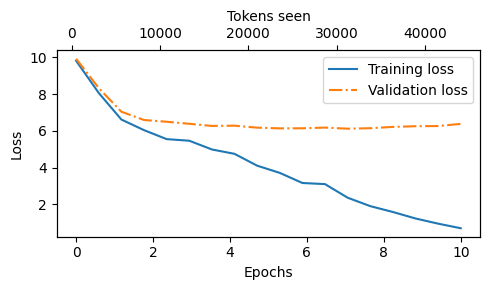

In [23]:
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator 

def plot_losses(epochs_seen , tokens_seen , train_losses , val_losses):
  fig , ax1 = plt.subplots(figsize=(5,3))
  ax1.plot(epochs_seen , train_losses , label = "Training loss")
  ax1.plot(epochs_seen , val_losses , linestyle='-.' , label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  
  # Create a second x-axis for tokens seen
  ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()  # Adjust layout to make room
  plt.savefig("loss-plot.pdf")
  plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness


In [24]:
model.to("cpu")
model.eval() 

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model = model , idx = text_to_token_ids("Every effort moves you" , tokenizer) , 
                                 max_new_tokens = 25 , context_size = GPT_CONFIG_124M['context_length'])
print(f"Output text:\n" , token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [25]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(f"probas {probas} {next_token_id}")
# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

probas tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]) 3
forward


In [26]:
torch.manual_seed(123)
print(f"aa {torch.multinomial(probas, num_samples=1)}")
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

aa tensor([7])
forward


In [27]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [28]:
def softmax_with_temperature(logits , temperature):
  scaled_logits = logits / temperature 
  return torch.softmax(scaled_logits , dim = 0 )

temperatures = [1 , 0.1 , 5]
scaled_probas = [softmax_with_temperature(next_token_logits , T) for T in temperatures]

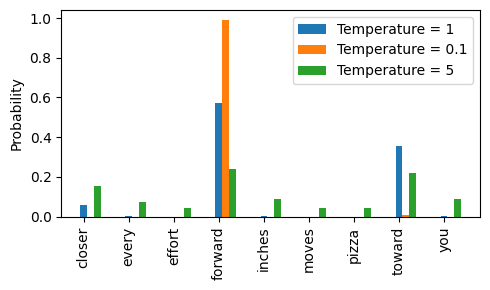

In [29]:
x = torch.arange(len(vocab))
bar_width = 0.15 

fig , ax = plt.subplots(figsize = (5,3))
for i , T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width , scaled_probas[i] , bar_width , label=f"Temperature = {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys() , rotation = 90)
ax.legend() 

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [30]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [31]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


### Top-K sampling


In [32]:
top_k = 3 
top_logits , top_pos = torch.topk(next_token_logits , top_k)
print("Top logits : " , top_logits) 
print("Top positions :" , top_pos)

Top logits :  tensor([6.7500, 6.2800, 4.5100])
Top positions : tensor([3, 7, 0])


In [33]:
new_logits = torch.where(condition = next_token_logits < top_logits[-1] , input = torch.tensor(float("-inf")) , other = next_token_logits)
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [34]:
topk_probas = torch.softmax(new_logits , dim = 0)
topk_probas

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

In [35]:
def generate(model , idx , max_new_tokens , context_size , temperature = 0. , top_k = None , eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[: , -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[: , -1 , :]
    if top_k is not None:
      top_logits , _ = torch.topk(logits ,top_k)
      min_val = top_logits[:, - 1]
      logits = torch.where(logits < min_val , torch.tensor(float('-inf')).to(logits.device) , logits)
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits , dim = -1)
      idx_next = torch.multinomial(probs , num_samples = 1)
    else :
      idx_next = torch.argmax(logits , dim=-1 , keepdim= True)
    if idx_next == eos_id:
      break 
    idx = torch.cat((idx , idx_next) , dim = 1)
  return idx

In [36]:
torch.manual_seed(123)

token_ids = generate(model = model , idx = text_to_token_ids("Every effort moves you" , tokenizer) , 
                     max_new_tokens = 15 , 
                     context_size =GPT_CONFIG_124M["context_length"] , 
                     top_k=25 , 
                     temperature = 1.4)
print("Output text:\n" , token_ids_to_text(token_ids , tokenizer))

Output text:
 Every effort moves you know began to my surpriselyed for nothing--I told Mrs.



## 5.4 Loading and saving model weights in PyTorch


In [37]:
torch.save(model.state_dict() , "model.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth" , map_location = device , weights_only = True))
model.eval()
print(" ")

In [38]:
torch.save({"model_state_dict" : model.state_dict() , "optimizer_state_dict" : optimizer.state_dict() }, "model_and_optimizer.pth")

In [39]:
checkpoint = torch.load("model_and_optimizer.pth" , weights_only= True)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters() , lr=54-4 , weight_decay = 0.1)
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 Loading pretrained weights from OpenAI

In [40]:
print("TensorFlow version:" , version("tensorflow"))
print("tqdm version:" , version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [41]:
from gpt_download import download_and_load_gpt2 
settings , params = download_and_load_gpt2(model_size="124M" , models_dir = "gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [42]:
settings , params.keys()

({'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12},
 dict_keys(['blocks', 'b', 'g', 'wpe', 'wte']))

In [43]:
print(params["wte"])
print("Token embedding weight tensor dimensions:" , params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [48]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length":1024 , "qkv_bias":True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [49]:
def assign(left , right):
    if left.shape != right.shape : 
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [54]:
import numpy as np 

def load_weights_into_gpt(gpt , params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight , params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight , params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device);

In [55]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle
